# Imports 

In [30]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import torch
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 62592
    })
})


## Split dataset

In [4]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
62587  An email released by WikiLeaks on Sunday appea...      1           0   
62588  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
62589  You know, because in fantasyland Republicans n...      1           0   
62590  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
62591  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   

       has_url  percent_uppercase  frequency_punctu

### Train with og 10 feats

In [5]:
from sklearn.model_selection import train_test_split

features_orig_10 = ['has_quotes', 'has_url', 'percent_uppercase', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'percent_whitespace', 'avg_sentence_length', 'frequency_punctuation']
seed = 45

y = df["label"]
x = df[features_orig_10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

display(x_train)
display(y_train)

,has_quotes,has_url,percent_uppercase,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,percent_whitespace,avg_sentence_length,frequency_punctuation
6312,0,1,3.210369,0,1,0,13,16.231306,17.958333,107
1575,0,1,2.939735,0,0,5,2,16.217540,20.470588,46
34150,0,0,2.004385,0,1,2,5,16.630128,23.125000,49
20440,0,1,4.370962,0,0,3,7,15.925504,21.950000,47
49987,0,0,3.140559,0,0,4,22,17.387974,16.837209,178
...,...,...,...,...,...,...,...,...,...,...
12895,0,1,2.826433,1,0,4,5,16.281847,17.360000,42
60960,0,1,2.833112,0,0,5,7,16.688800,18.136364,46
6012,0,1,13.148148,1,0,2,3,16.481481,18.800000,30
6558,1,1,2.282755,1,0,2,9,17.015154,19.872340,131


6312     1
1575     1
34150    0
20440    0
49987    0
        ..
12895    1
60960    1
6012     1
6558     0
56267    1
Name: label, Length: 50073, dtype: int64

NB multinomial needs numeric, remove non numerics

In [ ]:
# Convert dataset to pandas for easier implementation with sklearn
df = dataset["train"].to_pandas()
print("Dataset columns:", df.columns)
print("Data types:", df.dtypes)

# Check for any non-numeric values that might cause problems
for col in df.columns:
    if df[col].dtype == 'object':  # Check if column contains strings
        print(f"Column {col} contains non-numeric data and will be dropped")
        df = df.drop(columns=[col])

# Make sure all remaining columns are numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError as e:
        print(f"Error converting column {col}: {e}")
        # If conversion fails, we'll examine the problematic values
        problematic_rows = df[~pd.to_numeric(df[col], errors='coerce').notna()]
        if not problematic_rows.empty:
            print(f"Sample of problematic values in {col}:")
            print(problematic_rows[col].head())
            # Drop the problematic column if we can't convert it
            df = df.drop(columns=[col])

print("Final columns after cleaning:", df.columns)

### Training

no further preprocessing

In [6]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

Convert Negative values to 0 and scale features to [0,1]

In [7]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Initialize and train multinomialNB classifier

In [8]:
nb_multinomial = MultinomialNB()
nb_multinomial.fit(x_train_scaled, y_train)

MultinomialNB()

In [9]:
# Make predictions
y_pred = nb_multinomial.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5696940650211678


In [14]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.96      0.71      6984
           1       0.61      0.07      0.13      5535

    accuracy                           0.57     12519
   macro avg       0.59      0.52      0.42     12519
weighted avg       0.59      0.57      0.46     12519



In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[6736  248]
 [5139  396]]


## Visualize feature importance

examine log probabilities for naive Bayes ( not a tree )

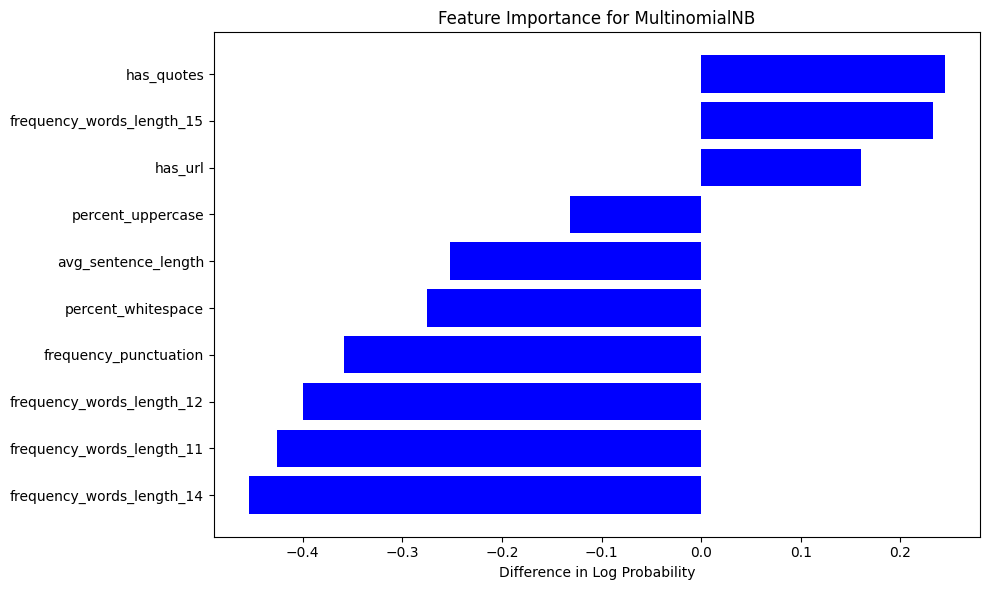

In [16]:
feature_importance = nb_multinomial.feature_log_prob_[1] - nb_multinomial.feature_log_prob_[0]
feature_names = x_train.columns

# Sort features by importance
indices = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance for MultinomialNB')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Difference in Log Probability')
plt.tight_layout()
plt.show()

## Tuning alpha parameter with cross-validation

In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Set up GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

Compare the parameters

In [18]:
# Print best parameters
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))


Best parameters found:  {'alpha': 1.0}
Best cross-validation accuracy: 0.5675


Evaluate model with best parameters

In [19]:
best_nb = grid_search.best_estimator_
y_pred_best = best_nb.predict(x_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))

Test accuracy with best parameters: 0.5697


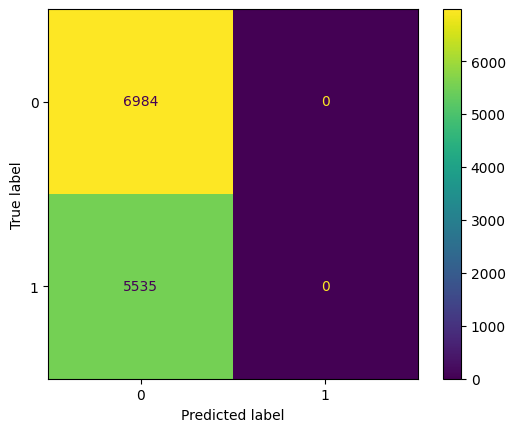

In [33]:
# Generate predictions with the best model
y_pred = best_nb.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Save the results

In [ ]:
import json
import os
from datetime import datetime

# Create a dictionary to store all results
results = {
    "model_name": "MultinomialNB",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": "WELFake_stylo_feats",
    "metrics": {
        "accuracy": float(accuracy),
        "best_accuracy": float(accuracy_best),
        "best_alpha": grid_search.best_params_["alpha"],
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": {}
    },
    "feature_importance": {feature: float(importance) for feature, importance in 
                          zip(feature_names, feature_importance)}
}

# Get classification report metrics
report = classification_report(y_test, y_pred, output_dict=True)
for class_label, metrics in report.items():
    if isinstance(metrics, dict):
        results["metrics"]["classification_report"][class_label] = {
            k: float(v) for k, v in metrics.items()
        }

# Ensure the results directory exists
if not os.path.exists('model_results'):
    os.makedirs('model_results')

# Save the results to a JSON file
filename = f"model_results/nb_multinomial_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {filename}")

# K-Fold Validation

In [20]:
from sklearn.model_selection import cross_val_score, KFold

# Setup k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create a new MultinomialNB classifier with the best alpha from grid search
best_alpha = grid_search.best_params_['alpha']
nb_cv = MultinomialNB(alpha=best_alpha)

# Perform k-fold cross-validation
cv_scores = cross_val_score(nb_cv, x_train_scaled, y_train, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f"K-fold Cross-Validation Results ({k_folds} folds):")
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# Train the final model on the entire training dataset
nb_final = MultinomialNB(alpha=best_alpha)
nb_final.fit(x_train_scaled, y_train)

K-fold Cross-Validation Results (5 folds):
CV Accuracy: 0.5676 ± 0.0051
Individual fold scores: [0.56225662 0.56974538 0.57134299 0.57389654 0.56091472]


MultinomialNB()

# Test on the gossicop dataset

In [25]:
# Load the external test dataset
from datasets import load_dataset
import pandas as pd
import numpy as np

test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
# test_df = external_test["train"].to_pandas()

# # Prepare the test features and labels
# X_external = test_df.drop(columns=['label', 'text'])
# y_external = test_df['label']

# # Print shapes and feature names for debugging
# print(f"Training features shape: {x_train_scaled.shape}")
# print(f"External test features shape: {X_external.shape}")

# # When the scaler isn't working, create a new one for the external data
# # This avoids cross-dataset compatibility issues while still normalizing the data
# external_scaler = MinMaxScaler()
# X_external_scaled = external_scaler.fit_transform(X_external)

# # Or alternatively, manually scale the features to the same range
# # X_external_scaled = (X_external - X_external.min()) / (X_external.max() - X_external.min())

# # Make predictions on the external test set
# external_predictions = nb_final.predict(X_external_scaled)

# # Evaluate performance on the external test set
# external_accuracy = accuracy_score(y_external, external_predictions)
# external_report = classification_report(y_external, external_predictions)
# external_conf_matrix = confusion_matrix(y_external, external_predictions)

# print("\nPerformance on external test dataset:")
# print(f"Accuracy: {external_accuracy:.4f}")
# print("Classification Report:")
# print(external_report)
# print("Confusion Matrix:")
# print(external_conf_matrix)

In [26]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df[features_orig_10]

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,percent_whitespace,avg_sentence_length,frequency_punctuation
0,1,0,5.102041,0,1,0,3,17.040816,14.916667,32
1,1,0,3.068897,4,6,26,10,15.636029,18.271186,181
2,1,1,3.742204,0,3,12,7,16.468666,16.619718,224
3,1,1,3.492849,0,2,3,7,16.529153,16.410256,107
4,1,0,3.040541,3,10,1,16,16.394026,19.816327,139
...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,0,0,0,1,18.042813,20.666667,5
6896,0,0,9.923664,0,0,0,0,16.793893,23.000000,25
6897,0,0,3.754171,0,1,5,1,15.656285,16.216216,94
6898,0,0,3.329065,0,0,0,1,17.669654,18.250000,36


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [ ]:
y_test_pred = best_nb.predict(x_test_set)
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred, average='weighted')
recall = recall_score(y_test_set, y_test_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

NameError: name 'f1_score' is not defined

# Feature Selection

In [34]:
from sklearn.feature_selection import SelectKBest, f_classif

# Remove the text column if present in your x_train dataset
features_for_selection = x_train.drop('text', axis=1, errors='ignore')

# Define the number of top features to select
num_features = 5  # You can adjust this number

# Use SelectKBest to identify top features
selector = SelectKBest(f_classif, k=num_features)
selector.fit(features_for_selection, y_train)

# Get selected feature indices and names
selected_indices = selector.get_support(indices=True)
selected_features = features_for_selection.columns[selected_indices]

print(f"\nTop {num_features} selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature} (Score: {selector.scores_[selected_indices[i]]:.2f})")

# Create datasets with only selected features
X_train_selected = features_for_selection.iloc[:, selected_indices]
X_test_selected = x_test.drop('text', axis=1, errors='ignore').iloc[:, selected_indices]

# Scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Train and evaluate model with selected features
nb_selected = MultinomialNB(alpha=best_alpha)
nb_selected.fit(X_train_selected_scaled, y_train)
selected_predictions = nb_selected.predict(X_test_selected_scaled)

# Evaluate performance with selected features
selected_accuracy = accuracy_score(y_test, selected_predictions)
selected_report = classification_report(y_test, selected_predictions)

print("\nPerformance with selected features:")
print(f"Accuracy: {selected_accuracy:.4f}")
print("Classification Report:")
print(selected_report)


Top 5 selected features:
1. has_quotes (Score: 268.11)
2. has_url (Score: 4443.98)
3. percent_uppercase (Score: 559.62)
4. frequency_words_length_15 (Score: 281.66)
5. percent_whitespace (Score: 239.81)

Performance with selected features:
Accuracy: 0.5692
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.96      0.71      6984
           1       0.61      0.07      0.13      5535

    accuracy                           0.57     12519
   macro avg       0.59      0.52      0.42     12519
weighted avg       0.59      0.57      0.45     12519

